# Neural-based channel decoders


## 1. Prerequisites:  

The purpose of this part of the work is to compare the BER of both a pre-trained neural decoder and the MAP decoder for a Polar code over an AWGN channel. 

In order to develop a neural based channel decoder you will need: 

- A communication chain which implements the polar code and its MAP decoder (under python)
- A working keras environment with the proper backend Tensorflow 


## 2. Training dataset and training:  

In order to train the neural network, you need to provide it with both: 
- Input sequences: the received $y^n$
- Label sequences (or targets) : the transmitted $u^k$

In order for the neural decoder to be able to recover the original information words, i.e., $u^k$, the neural decoder needs to be trained over all possible $u^k$ and therefore, all posssible codewords $c^n$. Thus, the label sequences need to cover all possibly transmitted sequences. 

The labels can be coded in two different manners: 
- Array representation: the output of the neural network is a vector of size k, which outputs for each bit $i \in [1:k]$, a possible value 0 or 1. . 
- One hot representation: the output of the neural networ is a vector of size $2^k$ which outputs $1$ only at the index of the information word transmitted, and 0 everywhere else. 

Question: In practice, the output of a neural network is never binary, but it rather has a soft value $ \in [0:1]$. Depending on the type of the network, two possible output activation functions can be used in order to output these soft values: sigmoid or softmax. Which function should we use for either strategies? 

In this project, we will use one-hot representations. 

## 3. Testing: 
Once the neural network is trained, you can test it in the communication chain you implemented before. 

## 4. Design meta-parameters: 

The performances of the neural decoder will be strongly related to the metaparameters chosen during training. 

Try and assess the effect of the different design metaparameters: 

- Training epochs
- Number of hidden layers
- Number of neurons per layer
- Activation functions
- Training SNR 
- Optimizer 
- Loss function: mse, crossentropy 


In [17]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber

# Configuration
MODULATION = 'BPSK'
G = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# Initialization
transmitter = Transmitter(MODULATION, G)
channel = AWGNChannel(MODULATION, G)
receiver = Receiver(MODULATION, G, ReceiverMode.MAP)

if __name__ == '__main__':
    t = time.time()
    # receiver.block_elements contains all possible u^k (labels)
    # receiver.block_coded_elements contains all possible codewords c^n
    
    k = np.size(G, 0)
    n = np.size(G, 1)
    
    # Create model
    # We are working with probability, to have sum(s_i) = 1 at the output, we use a softmax instead of a sigmoid activation function
    # Because we are using a hit representation, we use a 
    hot_model=Sequential()
    hot_model.add(Dense(20*2**k, activation='relu', input_dim=n))
    hot_model.add(Dense(2**k, activation='softmax', input_dim=n))
            
    SNR = 10**(1 / 10)
    
    noisy_model=Sequential()
    noisy_model.add(GaussianNoise(0.01, input_shape=(n,)))
    noisy_model.add(hot_model)
    
    noisy_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(noisy_model.summary())
    
    # Create labels for hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    noisy_history = noisy_model.fit(
        np.array(receiver.block_coded_elements), 
        np.array(labels), 
        epochs=5*10**3, 
        verbose=0
    )
    noisy_model.save('networks/decoder.h5')
    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 16)                0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 256)               1398016   
Total params: 1,398,016
Trainable params: 1,398,016
Non-trainable params: 0
_________________________________________________________________
None
Elapsed : 403.28 s


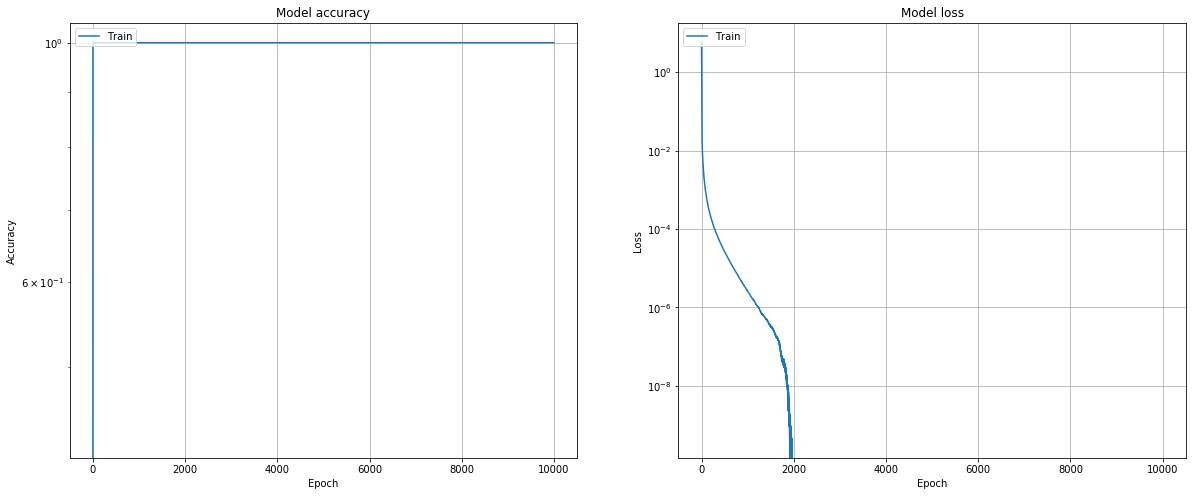

In [20]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
plt.grid()
plt.plot(noisy_history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(122)
plt.grid()
plt.plot(noisy_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.yscale('log')
# plt.subplots_adjust(wspace = 0.5)

Start EbN0 1/50 -15.0
Start EbN0 2/50 -14.53061224489796
Start EbN0 3/50 -14.061224489795919
Start EbN0 4/50 -13.591836734693878
Start EbN0 5/50 -13.122448979591837
Start EbN0 6/50 -12.653061224489797
Start EbN0 7/50 -12.183673469387756
Start EbN0 8/50 -11.714285714285714
Start EbN0 9/50 -11.244897959183673
Start EbN0 10/50 -10.775510204081632
Start EbN0 11/50 -10.306122448979592
Start EbN0 12/50 -9.83673469387755
Start EbN0 13/50 -9.36734693877551
Start EbN0 14/50 -8.89795918367347
Start EbN0 15/50 -8.428571428571427
Start EbN0 16/50 -7.959183673469387
Start EbN0 17/50 -7.489795918367347
Start EbN0 18/50 -7.020408163265306
Start EbN0 19/50 -6.551020408163264
Start EbN0 20/50 -6.081632653061224
Start EbN0 21/50 -5.612244897959183
Start EbN0 22/50 -5.142857142857142
Start EbN0 23/50 -4.673469387755102
Start EbN0 24/50 -4.204081632653061
Start EbN0 25/50 -3.7346938775510203
Start EbN0 26/50 -3.2653061224489797
Start EbN0 27/50 -2.795918367346939
Start EbN0 28/50 -2.3265306122448965
Start

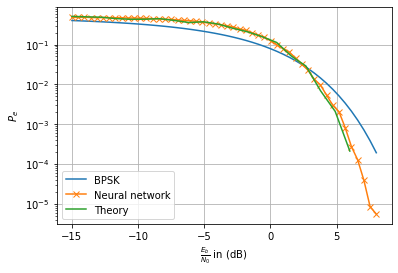

Elapsed : 250.26 s


In [19]:
import time

EbN0dBs = np.linspace(-15, 8, 50)

def channel_fnt(b, EbN0dB):
    c = transmitter.transmit(b)
    d = channel.process(c, EbN0dB)

    # Create blocks
    b_r = noisy_model.predict(np.array(np.split(d, len(d) // transmitter.block_coded_length)))
    
    b_r = np.array(list(map(lambda x: receiver.block_elements[np.argmax(x)], b_r)))
    b_r = b_r.flatten()

    return b_r, c, d

if __name__ == '__main__':
    t = time.time()
    BER = ber_performance(
        EbN0dBs,
        channel_fnt,
        np.size(G, 0) * 5000,
        80
    )
    
    [EbN0dBs_C, BER_C] = np.loadtxt('BER_G_MAP.csv', delimiter=',')
    
    # Plot results
    plt.figure()
    show_ber(MODULATION, EbN0dBs, BER)
    plt.plot(EbN0dBs_C, BER_C)
    plt.legend(['BPSK', 'Neural network', 'Theory'])
    plt.show()
    
    np.savetxt('BER_G_NEURAL.csv', [np.array(EbN0dBs), np.array(BER)], delimiter=',')
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')